Based on ds_tree.ipynb

This is the data structure based on the theory section of the thesis, which tries to be as minimal as possible.
We then have:
- constructor functions that can build this data structure. E.g:
    - random networks
    - sympy equation builder
    - manual solver structure builder
- mapping functions that can associate additional information with each datastructure. E.g:
    - openMDAO namer(or any other renamer)
    - mapping to actualy functions(that need to have the correct data shape for input and output)
- processing functions that extract useful information based on the datastructures. E.g:
    - returning all variables
    - get input variables
    - get output variables

# Example data structure
## Directed Graph

In [52]:
from collections import OrderedDict, defaultdict
import itertools
import networkx as nx
from representations import draw

In [106]:
Ein = {
    1: (7,),
    2: (3,6),
    3: (1,),
    4: (2,4),
    5: (3,2)
}
# IMPORTANT: Need to enforce that each output variable 
# can only be connected to one function
Eout = {
    1: (6,),
    2: (1,),
    3: (2,),
    4: (None,),
    5: (5,), # Use None to indicate the size of the output
}    

In [107]:
strnode = lambda var,fx, reverse=False: ('f_{}'.format(fx), 'x_{}'.format(var)) if reverse else ('x_{}'.format(var), 'f_{}'.format(fx)) 

In [108]:
G = nx.DiGraph([strnode(var,fx) for fx,vrs in Ein.items() for var in vrs]+[strnode(var, fx, True) for fx,vrs in Eout.items() for var in vrs if var])

In [110]:
var_names = ['x_{}'.format(var) for var in all_variables(Ein, Eout)]

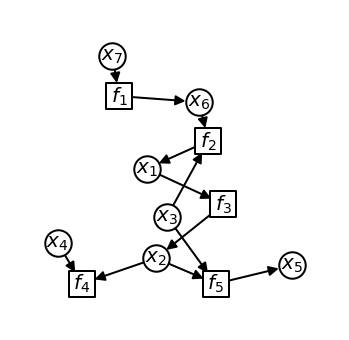

In [115]:
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G.nodes()}
draw(G, node_shape=node_shapes, prog='fdp');

## Ordered tree

In [132]:
Stree = {
    2:1
}
Ftree = OrderedDict((
    (1,1),
    (2,2),
    (3,2),
    (4,1),
    (5,1)
))
Vtree = {
    4:1
}

## Functions

In [117]:
f = {
    1: lambda x,y: (x+y),
    2: lambda x,y,z: (x+y+z),
    3: lambda x,y: (x+y),
    4: lambda x,y: (x+y),
    5: lambda x,y,z: (x+y)
}

# Processing functions

In [118]:
def all_varnodes(E, filterto=None):
    return {var for key,val in E.items() if not filterto or key in filterto for var in val}

In [119]:
def all_variables(Ein, Eout, filterto=None):
    return all_varnodes(Ein, filterto).union(all_varnodes(Eout, filterto)-{None})

In [120]:
def global_inputs(Ein, Eout, filterto=None):
    return all_varnodes(Ein, filterto)-all_varnodes(Eout, filterto)

In [121]:
def global_outputs(Ein, Eout, filterto=None):
    return all_varnodes(Eout, filterto)-all_varnodes(Ein, filterto)

In [122]:
all_variables(Ein, Eout)

{1, 2, 3, 4, 5, 6, 7}

In [123]:
global_inputs(Ein, Eout)

{3, 4, 7}

# Generating workflows

In [124]:
Ntree.keys()

odict_keys([1, 2, 3, 4, 5])

In [125]:
tree = {
    2:1,
}

In [126]:
def level_order_tree(tree, root=1):
    level_order = [root]
    next_dict = defaultdict(list)
    for key,val in tree.items():
        next_dict[val].append(key) 
    q = [root]
    while q:
        idx = q.pop()
        elts = next_dict[idx]
        level_order+=elts
        q+=elts
    return level_order

In [127]:
level_order_tree(tree)

[1, 2]

## Merging

In [128]:
mergelts = [2,3,4]

In [129]:
solver_vars = global_inputs(Ein, Eout, mergelts).intersection(global_inputs(Ein,Eout))

In [133]:
solver_vars # should actually be specified (but need to be part of allowable_solvevars)

{3, 4}

In [49]:
ins = global_inputs(Ein, Eout, mergelts)
outs = global_outputs(Ein, Eout, mergelts)

In [50]:
ins, outs

({3, 5, 6}, {None})

In [ ]:
solvefor = [] if solvefor == None else solvefor
allsolvevars = set()
for elt in mergelts:
    if elt.node_type == END and elt.ref in solvefor:
        allsolvevars.add(solvefor[elt.ref])
edges = G.edges()
mergededges = [(fr,to) for fr,to in edges if fr in mergelts or to in mergelts]
outs = {to for fr,to in edges if fr in mergelts and not all([elt in mergelts for elt in G.successors(to)])}
outs = outs.union(allsolvevars) # for every terminal node can have one solvefor
ins = {fr for fr,to in edges if (
    to in mergelts 
    and not any([elt in mergelts for elt in G.predecessors(fr)]) 
    and fr not in allsolvevars)}
newedges = [(fr, mergeinto) for fr in ins]+[(mergeinto, to) for to in outs]
if mergewithold:
    oldedges = [(fr, to) for fr,to in edges if fr not in mergelts and to not in mergelts]
    newedges += oldedges
# Tree
newG = nx.DiGraph(newedges)
childG = nx.DiGraph(mergededges)
return newG, childG

In [ ]:
m = branch_node.ref
_,sparsity,dout,_ = m.data_structures()
node_list = [tree_node for tree_node in PreOrderIter(branch_node) if tree_node.node_type in [INTER, END]]
sparsity_treeref = {tree_node: sparsity[tree_node.ref] for tree_node in node_list}
dout_treeref  = {tree_node: dout[tree_node.ref] for tree_node in node_list}
G, _ = digraph_repr(sparsity_treeref, dout_treeref, intermediary=True)
merge_order = solvers_bottom_up(branch_node, from_root)
newG = G
graphs = dict() 
for elt in merge_order:
    newG, childG = merge_pure(newG, elt.children, elt, solvefor=m.outset)
    graphs[elt] = childG
return G, graphs